<center><a target="_blank" href="https://www.sds2022.ch/"><img src="https://drive.google.com/uc?id=1S7k7kTXs9qIylw3C7LA9rHkLycjlY8te" width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>

<center><a target="_blank" href="http://www.sit.academy"><img src="https://drive.google.com/uc?id=1x9_jQgLhozCSWDSaOdVxKmxOEAe_OLgV" width="250" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center> <h1> Live Coding  </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>SIT Academy, 2022</center>



# MLFlow Workshop - Sequence 2 - Projects API

MLflow Projects are a standard format for packaging reusable data science code. Each project is simply a directory with code or a Git repository, and uses a descriptor file or simply convention to specify its dependencies and how to run the code. 

For example, projects can contain a `conda.yaml` file for specifying a Python Conda environment. When you use the `MLflow Tracking API` in a Project, MLflow automatically remembers the project version (for example, Git commit) and any parameters. 

You can easily run existing MLflow Projects from `GitHub` or your own Git repository, and chain them into multi-step workflows.


## Install dependencies

In [1]:
!pip -q install mlflow

     |████████████████████████████████| 17.8 MB 729 kB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 146 kB 62.3 MB/s 
     |████████████████████████████████| 209 kB 57.9 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 181 kB 48.0 MB/s 
     |████████████████████████████████| 596 kB 53.3 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 78 kB 6.0 MB/s 


By default, MlFlow uses conda to create a temporary virtual environment for each run.

There is a helper package that makes installing Conda on Google Colab a breeze:

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:46
🔁 Restarting kernel...


*Note: Your kernel will probably restart after setting up Conda. Don't be alarmed.*

In [3]:
!conda --version

conda 4.9.2


Let's also create a minimal conda environment YAML config file that Mlflow will use later. (We won't be creating the environment ourselves at this point.)

In [7]:
%%writefile mlflow_swisshousing.yml

name: swisshousing
channels:
  - conda-forge
dependencies:
  - python=3.7
  - pandas=1.3.5
  - scikit-learn=1.0.2
  - pip
  - pip:
    - mlflow

Overwriting mlflow_swisshousing.yml


## Setting up our script for the command line

First, we need to add a way for MLFlow to be able to pass arguments to our script(s).

Now, let's clean up the script and add a few lines of code that will allow us to pass in arguments to allow for adjustable runs.

In [9]:
%%writefile mlflow_swisshousing_train.py

# -*- coding: utf-8 -*-
#EX1_MLFlow_Tracking_Regression_SwissHousing.ipynb
#Automatically generated by Colaboratory.

#Original file is located at
#    https://colab.research.google.com/drive/1Rl3N-X41fKfyZ-c-hQ9qPK48B5O1wQ-H

# Load Dependencies

import os
import warnings
import sys

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import mlflow
import mlflow.sklearn

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

########
# Command-line args - passed in by MLFlow
print(sys.argv)
model_type = sys.argv[1]
alpha = float(sys.argv[2])
l1_ratio = float(sys.argv[3])
########

"""# Utilities for Data and Metrics"""

def prepare_data():
    #id = 1eNTyJc4jXJMkLPXW0eY6LL7_P9YN1GWO
    warnings.filterwarnings("ignore")
    np.random.seed(42)

    # Read the home price csv file from the URL
    orig_url = "https://drive.google.com/file/d/1eNTyJc4jXJMkLPXW0eY6LL7_P9YN1GWO/view"
    file_id = orig_url.split('/')[-2]
    data_path='https://drive.google.com/uc?export=download&id=' + file_id
    
    try:
        data = pd.read_csv(data_path)
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e)
    
    #numbers are written in this format "1,235,00" converting them to integers
    data["price"] = data["price"].str.replace(',', '')
    data["price"] = pd.to_numeric(data["price"])
    data = data.drop(["Unnamed: 0", 'zip'], 1)
    data = data.dropna()

    y = data["price"]
    X = data.drop("price", 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

"""# Load Dataset"""

X_train, X_test, y_train, y_test = prepare_data()

data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

data['X_train'].head()

data['y_train'].head()

"""# Utilities for Modeling and Tracking Experiments"""

def train_elasticnet(data, alpha=0.5, l1_ratio=0.5):

    # Train and track experiment
    with mlflow.start_run():

        categorical_features = ['type', 'floor', 'city', 'canton']
        continious_features = ['room_num', 'area_m2', 'floors_num', 'year_built', 'last_refurbishment', 'lat', 'lon']

        numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

        categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

        preprocessor = ColumnTransformer( transformers = [("num", numeric_transformer, continious_features),
                    ("cat", categorical_transformer, categorical_features)])

        # Execute ElasticNet
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        pipeline_lr = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", lr)])
        pipeline_lr.fit(data['X_train'], data['y_train'])

        # Evaluate Metrics
        predicted_qualities = pipeline_lr.predict(data['X_test'])
        (rmse, mae, r2) = eval_metrics(data['y_test'], predicted_qualities)

        # Print out metrics
        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('Model', 'ElasticNet')  
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(pipeline_lr, "model")

def train_random_forest(data, n_trees=100, max_depth=None):

    # Train and track experiment   
    with mlflow.start_run():

        categorical_features = ['type', 'floor', 'city', 'canton']
        continious_features = ['room_num', 'area_m2', 'floors_num', 'year_built', 'last_refurbishment', 'lat', 'lon']

        numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

        categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

        preprocessor = ColumnTransformer( transformers = [("num", numeric_transformer, continious_features),
                    ("cat", categorical_transformer, categorical_features)])
        
        # Execute RF
        rf = RandomForestRegressor(n_estimators=n_trees, max_depth=max_depth, random_state=42)
        pipeline_rf = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", rf)])
        pipeline_rf.fit(data['X_train'], data['y_train'])

        # Evaluate Metrics
        predicted_qualities = pipeline_rf.predict(data['X_test'])
        (rmse, mae, r2) = eval_metrics(data['y_test'], predicted_qualities)

        # Print out metrics
        print("Random Forest model (n_estimators={}, max_depth={}):".format(n_trees, max_depth))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('Model', 'Random Forest')  
        mlflow.log_param("n_estimators", n_trees)
        mlflow.log_param("max_depth", max_depth)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(pipeline_rf, "model")

#######################################

if model_type == "elastic_net" or "en":
  train_elasticnet(data, alpha, l1_ratio)
elif model_type == "random_forest" or "rf":
  train_random_forest(data, n_trees=100, max_depth=None)
elif model_type == "all":
  train_random_forest(data, n_trees=100, max_depth=None)
  train_elasticnet(data, alpha, l1_ratio)

Overwriting mlflow_swisshousing_train.py


If you are more comfortable using an IDE, you can first download your Colab notebook as a Python (.py) script.

Click on File and navigate to the bottom of the selections:
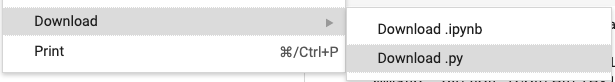

### Command-line Arguments

**Positional (simple):**

In [ ]:
# import sys

# alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
# l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5

**Keyword & positional (recommended):**

In [ ]:
# import argparse

# parser = argparse.ArgumentParser()

# parser.add_argument("-a", "--alpha", type=float,
#                     help="Regularization strength of penalty; should be between 0 and 1.")
# parser.add_argument("-l1", "--l1ratio", type=float,
#                     help="ElasticNet mixing parameter. If l1_ratio = 1, then L1 penalty. If l1_ratio = 0, then L2 penalty.")

# parser.parse_args()

## MLFlow Projects

Let's go back to our housing value predictor model run example. Imagine that we were happy with our model and wanted to share it with colleagues/others, including those with less technical backgrounds.

Let's try packaging what we did with a the `MLFlow Projects API`, and encoding what we did in a `MLProject` *yaml* file.

### `MLProject` *YAML* file

First, let's look at the anatomy of an `MLProject` file.



*   *MLProject* yaml file
  - parameters
  - entrypoints


```yaml
name: My Project

conda_env: my_env.yaml
# Can have a docker_env instead of a conda_env, e.g.
# docker_env:
#    image:  mlflow-docker-example

entry_points:
  main:
    parameters:
      data_file: path
      regularization: {type: float, default: 0.1}
    command: "python train.py -r {regularization} {data_file}"
  validate:
    parameters:
      data_file: path
    command: "python validate.py {data_file}"
```

[CLI](https://mlflow.org/docs/latest/cli.html#cli):

In [14]:
# command-line
!mlflow run https://github.com/mlflow/mlflow-example.git -P alpha=0.5

2022/06/22 06:47:15 INFO mlflow.projects.utils: === Fetching project from https://github.com/mlflow/mlflow-example.git into /tmp/tmp1rewxdxk ===
2022/06/22 06:47:16 INFO mlflow.utils.conda: Conda environment mlflow-1abc00771765dd9dd15731cbda4938c765fbb90b already exists.
2022/06/22 06:47:16 INFO mlflow.projects.utils: === Created directory /tmp/tmpo49kea9p for downloading remote URIs passed to arguments of type 'path' ===
2022/06/22 06:47:16 INFO mlflow.projects.backend.local: === Running command 'source activate mlflow-1abc00771765dd9dd15731cbda4938c765fbb90b 1>&2 && python train.py 0.5 0.1' in run with ID 'cec3bcb9d7d04ee8be0bc8acad222d3f' === 
/usr/local/envs/mlflow-1abc00771765dd9dd15731cbda4938c765fbb90b/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/usr/local/envs/mlflow-1a

Now let's try adapting it to our housing example!

## House price example - MLProject YAML file

```yaml
name: swiss_housing_price_prediction

entry_points:
  main:
    parameters:
      model_type: {type: str, default: 'all'}
      alpha: {type: float, default: 0.5}
      l1_ratio: {type: float, default: 0.5}
    command: "python mlflow_swisshousing_train.py {model_type} {alpha} {l1_ratio}"
```

In [6]:
%%writefile MLProject

name: swiss_housing_price_prediction

conda_env: mlflow_swisshousing.yml

entry_points:
  main:
    parameters:
      model_type: {type: str, default: 'all'}
      alpha: {type: float, default: 0.5}
      l1_ratio: {type: float, default: 0.5}
    command: "python mlflow_swisshousing_train.py {model_type} {alpha} {l1_ratio}"

Overwriting MLProject


## Running MLFlow from our *MLProject* file

Now let's try running our project, and try changing a parameter between runs.

In [11]:
!mlflow run . -P alpha=0.1

2022/06/22 06:46:29 INFO mlflow.utils.conda: Conda environment mlflow-e0c446dee95e6fb93f2aecb483fbe9de4f283635 already exists.
2022/06/22 06:46:29 INFO mlflow.projects.utils: === Created directory /tmp/tmpu18w59od for downloading remote URIs passed to arguments of type 'path' ===
2022/06/22 06:46:29 INFO mlflow.projects.backend.local: === Running command 'source activate mlflow-e0c446dee95e6fb93f2aecb483fbe9de4f283635 1>&2 && python mlflow_swisshousing_train.py all 0.1 0.5' in run with ID '5b15e97a2e77454081b8e4af3e806056' === 
['mlflow_swisshousing_train.py', 'all', '0.1', '0.5']
Elasticnet model (alpha=0.100000, l1_ratio=0.500000):
  RMSE: 1140541.9286590088
  MAE: 585480.8221569419
  R2: 0.6197609279239793
2022/06/22 06:46:34 INFO mlflow.projects: === Run (ID '5b15e97a2e77454081b8e4af3e806056') succeeded ===


In [20]:
!mlflow run . -P alpha=0.4 -P l1_ratio=0.2

2022/06/22 06:49:09 INFO mlflow.utils.conda: Conda environment mlflow-e0c446dee95e6fb93f2aecb483fbe9de4f283635 already exists.
2022/06/22 06:49:09 INFO mlflow.projects.utils: === Created directory /tmp/tmpvvnlm04l for downloading remote URIs passed to arguments of type 'path' ===
2022/06/22 06:49:09 INFO mlflow.projects.backend.local: === Running command 'source activate mlflow-e0c446dee95e6fb93f2aecb483fbe9de4f283635 1>&2 && python mlflow_swisshousing_train.py all 0.4 0.2' in run with ID '595c60a530b8419fa43d19fd872f9d0d' === 
['mlflow_swisshousing_train.py', 'all', '0.4', '0.2']
Elasticnet model (alpha=0.400000, l1_ratio=0.200000):
  RMSE: 1285325.3419525225
  MAE: 672852.8881851577
  R2: 0.5170964798757858
2022/06/22 06:49:13 INFO mlflow.projects: === Run (ID '595c60a530b8419fa43d19fd872f9d0d') succeeded ===


## Checking the results with `mlflow ui`

In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [ ]:
!mlflow ui --port 5000

## Running MLFlow Projects without the command line

Via Python:

In [ ]:
#mlflow.projects.run(
mlflow.run(
    uri,
    entry_point='main',
    version=None,
    parameters=None, #dict of params, e.g. {"alpha": 0.5, "l1_ratio": 0.01}
    docker_args=None,
    experiment_name=None,
    experiment_id=None,
    backend='local',
    backend_config=None,
    #storage_dir=None,
    synchronous=True,
    run_id=None,
    run_name=None,
    env_manager="local" #conda is default
    )